<a href="https://colab.research.google.com/github/xxxtraa/Movement-classifier/blob/main/basic_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition LSTM Analysis
dataset source: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

## Setup

Import libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.backend import one_hot
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

Set variables to load data

In [ ]:
cur_dir = 'drive/My Drive/Colab Notebooks/2 Fall 2020/CMPE 258/group_project/UCI-HAR-Dataset/'
train_dir = cur_dir + 'train'
test_dir = cur_dir + 'test'

In [ ]:
# total acceleration, body gyroscope, body acceleration
measurements = ['total_acc', 'body_gyro', 'body_acc']
# x, y, z dimensions
dimensions = ['x', 'y', 'z']

## Load data

Function to load data (x)

In [ ]:
def load_data(data_type, dir):
    data = []

    for m in measurements:
        for d in dimensions:
            filename = dir + '/Inertial Signals/' + m + '_' + d + '_' + data_type + '.txt'
            # print('Load data from', filename)
            
            vector = pd.read_csv(filename, header=None, delim_whitespace=True).to_numpy()
            # print('vector shape', vector.shape)
            
            data.append(vector)

    # print('Done loading data')
    # transform so each row is 128 x 9 feature vector w/ measurements at each timestep
    data = np.dstack(data)
    # print('data shape', data.shape, '\n')

    return data

Function to load labels (y)

In [ ]:
def load_labels(data_type, dir):
    filename = dir + '/y_' + data_type + '.txt'
    # print('Load labels from', filename)

    labels = pd.read_csv(filename, header=None, delim_whitespace=True).to_numpy()
    labels = labels.reshape(labels.shape[0])

    # use one hot encoding
    # labels = one_hot(labels, 6)
    labels = to_categorical(labels)
    # print('labels shape', labels.shape)

    return labels

Function to load entire dataset

In [ ]:
def load_dataset():
    return load_data('train', train_dir), load_labels('train', train_dir), \
                load_data('test', test_dir), load_labels('test', test_dir)

Load the train and test data

In [ ]:
x_train, y_train, x_test, y_test = load_dataset()

In [ ]:
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (7352, 128, 9) (7352, 7)
test (2947, 128, 9) (2947, 7)


## Basic LSTM model

Create, fit, and evaluate basic LSTM model

In [ ]:
def evaluate_basic_lstm(x_train, y_train, x_test, y_test, verbose):
    epochs = 256
    batch_size = 64

    num_timesteps = x_train.shape[1]
    num_features = x_train.shape[2]
    num_outputs = y_train.shape[1]

    # create the model
    basic_model = Sequential()
    basic_model.add(LSTM(100, input_shape=(num_timesteps, num_features)))
    basic_model.add(Dropout(0.5))
    basic_model.add(Dense(100, activation='relu'))
    basic_model.add(Dense(num_outputs, activation='softmax'))
    basic_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit
    # print('Fit:')
    basic_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # evaluate
    # print('Evaluate:')
    _, accuracy = basic_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=verbose)
    return accuracy, basic_model

In [ ]:
# accuracy, basic_model = evaluate_basic_lstm(x_train, y_train, x_test, y_test, 1)
# print(accuracy)

Evaluate the basic LSTM model multiple times

In [ ]:
x_train, y_train, x_test, y_test = load_dataset()
accuracy_list_basic = []

for i in range(10):
    accuracy, basic_model = evaluate_basic_lstm(x_train, y_train, x_test, y_test, 0)
    accuracy *= 100
    print('%d: %.3f' % (i+1, accuracy))
    accuracy_list_basic.append(accuracy)

print(accuracy_list_basic)
print('avg %.3f, std dev %.3f' % (np.mean(accuracy_list_basic), np.std(accuracy_list_basic)))

In [ ]:
print('basic LSTM model')
basic_model.summary()

basic LSTM model
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 707       
Total params: 54,807
Trainable params: 54,807
Non-trainable params: 0
_________________________________________________________________


## Convolutional LSTM model (ConvLSTM)
ConvLSTM2D from keras expects input data to have the shape (samples, time, rows, cols, channels), so the input data needs to be reshaped before fitting and evaluating the ConvLSTM model.

In [ ]:
def evaluate_conv_lstm(x_train, y_train, x_test, y_test, verbose):
    epochs = 256
    batch_size = 64

    num_timesteps = x_train.shape[1]
    num_features = x_train.shape[2]
    num_outputs = y_train.shape[1]

    # reshape data into subsequences (samples, timesteps, rows, cols, channels)
    timesteps = 4
    rows = 1
    cols = 32
    channels = num_features
    x_train = x_train.reshape((x_train.shape[0], timesteps, rows, cols, channels))
    x_test = x_test.reshape((x_test.shape[0], timesteps, rows, cols, channels))

    # create the model
    conv_model = Sequential()
    conv_model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', \
                            input_shape=(timesteps, rows, cols, channels)))
    conv_model.add(Dropout(0.5))
    conv_model.add(Flatten())
    conv_model.add(Dense(100, activation='relu'))
    conv_model.add(Dense(num_outputs, activation='softmax'))
    conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit
    conv_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # evaluate
    _, accuracy = conv_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=verbose)
    return accuracy, conv_model

In [ ]:
# accuracy, conv_model = evaluate_conv_lstm(x_train, y_train, x_test, y_test, 1)
# print(accuracy)

Evaluate the ConvLSTM model multiple times

In [ ]:
x_train, y_train, x_test, y_test = load_dataset()
accuracy_list_conv = []

for i in range(10):
    accuracy, conv_model = evaluate_conv_lstm(x_train, y_train, x_test, y_test, 0)
    accuracy *= 100
    print('%d: %.3f' % (i+1, accuracy))
    accuracy_list_conv.append(accuracy)

print(accuracy_list_conv)
print('avg %.3f, std dev %.3f' % (np.mean(accuracy_list_conv), np.std(accuracy_list_conv)))

In [ ]:
print('ConvLSTM model')
conv_model.summary()

ConvLSTM model
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_9 (ConvLSTM2D)  (None, 1, 30, 64)         56320     
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 30, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               192100    
_________________________________________________________________
dense_39 (Dense)             (None, 7)                 707       
Total params: 249,127
Trainable params: 249,127
Non-trainable params: 0
_________________________________________________________________


## Compare basic LSTM and ConvLSTM

Statistics for basic LSTM

In [ ]:
index = [i for i in range(10)]
pd.options.display.float_format = '{:,.3f}'.format

basic_df = pd.DataFrame(accuracy_list_basic, index=index, columns=['Basic LSTM'])
basic_df.loc['min'] = [np.amin(accuracy_list_basic)]
basic_df.loc['max'] = [np.amax(accuracy_list_basic)]
basic_df.loc['avg'] = [np.mean(accuracy_list_basic)]
basic_df.loc['std dev'] = [np.std(accuracy_list_basic)]

basic_df

Statistics for ConvLSTM

In [ ]:
conv_df = pd.DataFrame(accuracy_list_conv, index=index, columns=['ConvLSTM'])
conv_df.loc['min'] = [np.amin(accuracy_list_conv)]
conv_df.loc['max'] = [np.amax(accuracy_list_conv)]
conv_df.loc['avg'] = [np.mean(accuracy_list_conv)]
conv_df.loc['std dev'] = [np.std(accuracy_list_conv)]

conv_df

Statistics for both basic LSTM and ConvLSTM

In [ ]:
combined_df = basic_df.copy()
combined_df.insert(1, 'ConvLSTM', conv_df['ConvLSTM'].values)

combined_df

,Basic LSTM,ConvLSTM
1,86.868,91.483
2,88.972,91.653
3,90.193,89.922
4,88.225,90.736
5,90.397,92.331
6,91.449,90.601
7,90.092,90.397
8,90.397,90.092
9,90.126,90.329
10,89.345,90.159


## Confusion Matrix

In [ ]:
# sklearn/keras 
from sklearn import metrics
import matplotlib.pyplot as plt

Confusion matrix for basic LSTM

[[425  32  37   0   2   0]
 [  0 431  40   0   0   0]
 [  0   1 419   0   0   0]
 [  0  22   0 378  91   0]
 [  1   5   0  83 443   0]
 [  0   0   0   0   0 537]]


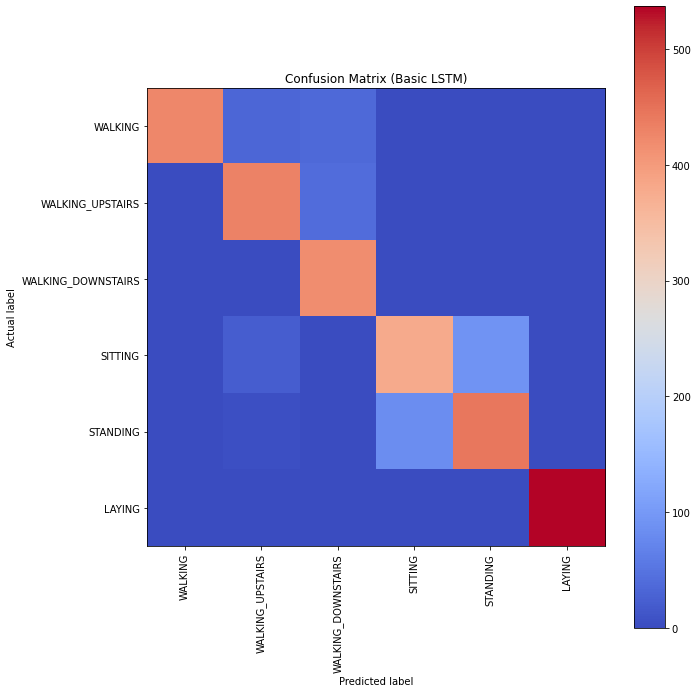

In [ ]:
y_pred_basic = basic_model.predict(x_test)

confusion_matrix_basic = metrics.confusion_matrix(y_test.argmax(1), y_pred_basic.argmax(1))
print(confusion_matrix_basic)

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix_basic, interpolation='nearest', cmap=plt.cm.coolwarm)
plt.title("Confusion Matrix (Basic LSTM)")
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Confusion matrix for ConvLSTM

[[482   4  10   0   0   0]
 [ 25 422  24   0   0   0]
 [ 15   5 400   0   0   0]
 [  0  25   0 400  66   0]
 [  3   5   1  80 443   0]
 [  0  27   0   0   0 510]]


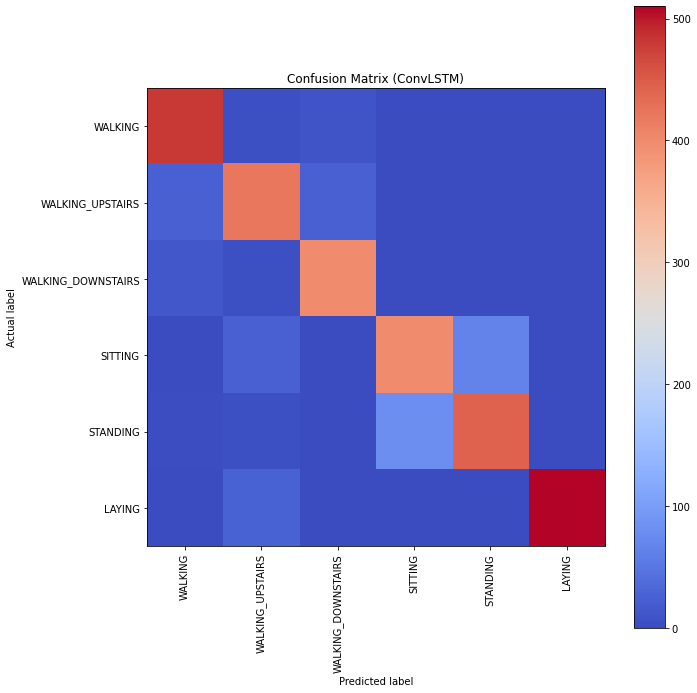

In [ ]:
# reshape data into subsequences (samples, timesteps, rows, cols, channels)
timesteps = 4
rows = 1
cols = 32
channels = x_train.shape[2]
x_test_reshape = x_test.reshape((x_test.shape[0], timesteps, rows, cols, channels))

y_pred_conv = conv_model.predict(x_test_reshape)
confusion_matrix_conv = metrics.confusion_matrix(y_test.argmax(1), y_pred_conv.argmax(1))
print(confusion_matrix_conv)

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix_conv, interpolation='nearest', cmap=plt.cm.coolwarm)
plt.title("Confusion Matrix (ConvLSTM)")
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()